# 將 YOLO 找出標記位置轉為0, 1組成的 Acne Feature Map，並作為第4個channel匯出


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import pickle

In [2]:
# 起點在左上
def convert2map(data, img_size=(640, 640)):
    
    mask = np.zeros(img_size, dtype=int)
    img_width, img_height = img_size

    # 填充目標區域
    for prediction in data:
        x_center = prediction["x"] * img_width
        y_center = prediction["y"] * img_height
        width = prediction["width"] * img_width
        height = prediction["height"] * img_height

        # 計算左上右下座標
        x_start = max(0, int(x_center - width / 2))
        x_end = min(img_width, int(x_center + width / 2))
        y_start = max(0, int(y_center - height / 2))
        y_end = min(img_height, int(y_center + height / 2))

        # 在目標區域內填充 1
        mask[y_start:y_end, x_start:x_end] = 1
    
    return mask

In [1]:
file_jpg = "acne2noacne/testA/levle1_186.jpg"
file_txt = "acne2noacne/testA_label/levle1_186.txt"
df = pd.read_csv(file_txt, sep=' ', engine='python')
data_dict = df.to_dict(orient='records')


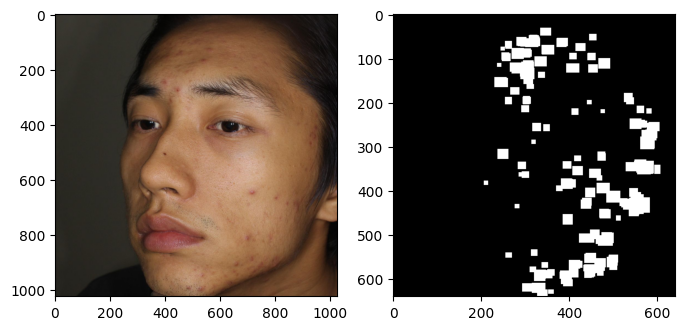

In [ ]:
# data = [
#     {"x": 0.6, "y": 0.1, "width": 0.5, "height": 0.1},
#     {"x": 0.1, "y": 0.6, "width": 0.1, "height": 0.5},
#     {"x": 0.7, "y": 0.7, "width": 0.2, "height": 0.2}
# ]

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
img = plt.imread(file_jpg) 
plt.imshow(img)

plt.subplot(1, 2, 2)
mask = convert2map(data_dict, (640, 640))
plt.imshow(mask, cmap='gray')
plt.show()

### 建立 4 channel 的 feature map

In [42]:
def convert2map2(data, img_size):
    
    mask = np.zeros(img_size, dtype=int)
    img_width, img_height = img_size

    # 填充目標區域
    for prediction in data:
        x_center = prediction["x"] * img_width
        y_center = prediction["y"] * img_height
        width = prediction["width"] * img_width
        height = prediction["height"] * img_height

        # 計算左上右下座標
        x_start = max(0, int(x_center - width / 2))
        x_end = min(img_width, int(x_center + width / 2))
        y_start = max(0, int(y_center - height / 2))
        y_end = min(img_height, int(y_center + height / 2))

        # 在目標區域內填充 1
        # mask[y_start:y_end, x_start:x_end] = 1
        # 把機率做轉換 讓小的放大
        mask[y_start:y_end, x_start:x_end] = np.sqrt(prediction["conf"]) * 255
    
    return mask

In [51]:
ori_trainA = r'acne2noacne/trainA'
ori_testA = r'acne2noacne/testA'
ori_trainB = r'acne2noacne/trainB'
ori_testB = r'acne2noacne/testB'
OD_trainA = r'OD_preliminary/trainA_label'
OD_testA = r'OD_preliminary/testA_label'


channel4 = r'acne2noacne_4channel'
if not os.path.exists(channel4):
    os.makedirs(channel4)

# trainA = r'acne2noacne_4channel/trainA'
# testA = r'acne2noacne_4channel/testA'
# trainB = r'acne2noacne_4channel/trainB'
# testB = r'acne2noacne_4channel/testB'
# if not os.path.exists(trainA):
#     os.makedirs(trainA)
# if not os.path.exists(testA):
#     os.makedirs(testA)
# if not os.path.exists(trainB):
#     os.makedirs(trainB)
# if not os.path.exists(testB):
#     os.makedirs(testB)

In [31]:
# 打開照片與label
trainA_img = glob.glob(ori_trainA + r'/*.jpg', recursive=True)
trainA_label = glob.glob(OD_trainA + r'/*.txt', recursive=True)
testA_img = glob.glob(ori_testA + r'/*.jpg', recursive=True)
testA_label = glob.glob(OD_testA + r'/*.txt', recursive=True)

trainB_img = glob.glob(ori_trainB + r'/*.jpg', recursive=True)
testB_img = glob.glob(ori_testB + r'/*.jpg', recursive=True)
print(len(trainA_img), len(trainA_label), len(testA_img), len(testA_label), len(trainB_img), len(testB_img))


719 719 80 80 820 119


In [39]:
# A: 有痘痘 B: 沒痘痘
def channel4(acneimg, acnelabel=None):
    save = []
    if acnelabel is not None:
        for i in range(len(acneimg)):
            img = plt.imread(acneimg[i])
            df = pd.read_csv(acnelabel[i], sep=' ', engine='python')
            data_dict = df.to_dict(orient='records')
            mask = convert2map2(data_dict, (img.shape[0], img.shape[1]))

            new_img = np.dstack((img, mask))
            save.append(new_img)
    else:
        for i in range(len(acneimg)):
            img = plt.imread(acneimg[i])
            new_img = np.dstack((img, np.zeros(img.shape[:2])))
            save.append(new_img)
            
    return save

In [52]:
trainA_c4 = channel4(trainA_img, trainA_label)
testA_c4 = channel4(testA_img, testA_label)
trainB_c4 = channel4(trainB_img)
testB_c4 = channel4(testB_img)

print(len(trainA_c4), len(testA_c4), len(trainB_c4), len(testB_c4))

print(trainA_c4[0].shape)
print(testA_c4[0].shape)
print(trainB_c4[0].shape)
print(testB_c4[0].shape)

719 80 820 119
(1024, 1024, 4)
(1024, 1024, 4)
(200, 200, 4)
(200, 200, 4)


In [55]:
with open (channel4 + r'/trainA_c4.pkl', 'wb') as f:
    pickle.dump(trainA_c4, f)
with open (channel4 + r'/testA_c4.pkl', 'wb') as f:
    pickle.dump(testA_c4, f)
with open (channel4 + r'/trainB_c4.pkl', 'wb') as f:
    pickle.dump(trainB_c4, f)
with open (channel4 + r'/testB_c4.pkl', 'wb') as f:
    pickle.dump(testB_c4, f)